<a href="https://colab.research.google.com/github/hisics/-datawhisperers_final-project_dsml2021/blob/bhavya/datawhisperers_sentiment_analysis_amazon_apparel_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b>Capstone Project - ML on Apparel Reviews at Amazon US
The Data Whisperers Team ✨  Amba | Bhavya | Sushma | Heba

#### Chosen project : Option 8 - Sentiment Analysis for Ecommerce | Apparel
---



<b>Objectives</b>
- Product owner's perspective: 
  - Quality improvement |
  - Gap analysis | same product different maker?
  - Reputation management
- Investor's perspective: 
  - which product owners improve over time
- Consumer perspective
  - Influencial posts

- ML Practice | Inferrential analysis for positive or negative feedback on products in social media product  


---
Notes: 
* #todo : means to check or come back to the code

<b>Understanding the Dataset</b>

* marketplace       : 2 letter country code of the marketplace where the review was written.
*customer_id       : Random identifier that can be used to aggregate *reviews written by a single author.
*review_id         : The unique ID of the review.
*product_id        : The unique Product ID the review pertains to. In the multilingual dataset the reviews for the same product in different countries can be grouped by the same product_id.
*product_parent    : Random identifier (can be used to aggregatereviews for the same product).
*product_title     : Title of the product.
*product_category  : Broad product category.
*star_rating       : The 1-5 star rating of the review.
*helpful_votes     : Number of helpful votes.
*total_votes       : Number of total votes the review received.
*vine              : Review was written as part of the Vine program.
*verified_purchase : The review is on a verified purchase.
*review_headline   : The title of the review.
*review_body       : The review text.
*review_date       : The date the review was written.

From Dany: Look at this document for reference,<br/>
https://colab.research.google.com/drive/1g6ZtYOOhGUj1WsiPpeaVPp5T7VFw234e?usp=sharing

https://www.tensorflow.org/datasets/catalog/amazon_us_reviews

#### Importing libaries and Apparel dataset

In [1]:
# (1) Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

In [2]:
# (2) Download product reviews from Amazon Datasets
# You can use reviews from Amazon Datasets for a particular product.
# Note that the data are quite large so do not run this cell unless you are willing to wait!
# For reference, visit:
# https://www.tensorflow.org/datasets/catalog/amazon_us_reviews
# https://s3.amazonaws.com/amazon-reviews-pds/readme.html
!curl -O https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Apparel_v1_00.tsv.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  618M  100  618M    0     0  31.0M      0  0:00:19  0:00:19 --:--:-- 32.8M


In [3]:
!echo "y" | gzip -d amazon_reviews_us_Apparel_v1_00.tsv.gz

In [4]:
# (3.a) Read the contents of the folder 
!ls

amazon_reviews_us_Apparel_v1_00.tsv  sample_data


In [5]:
# (3.b) Explore data (see what is categorial and numerical)

In [6]:
df = pd.read_table('amazon_reviews_us_Apparel_v1_00.tsv', delim_whitespace=False, error_bad_lines=False, nrows=300000)
df.info()

b'Skipping line 49396: expected 15 fields, saw 22\nSkipping line 57008: expected 15 fields, saw 22\n'
b'Skipping line 82075: expected 15 fields, saw 22\nSkipping line 104435: expected 15 fields, saw 22\nSkipping line 109766: expected 15 fields, saw 22\nSkipping line 124024: expected 15 fields, saw 22\nSkipping line 129914: expected 15 fields, saw 22\nSkipping line 130172: expected 15 fields, saw 22\n'
b'Skipping line 161515: expected 15 fields, saw 22\n'
b'Skipping line 230464: expected 15 fields, saw 22\n'
b'Skipping line 292640: expected 15 fields, saw 22\nSkipping line 293681: expected 15 fields, saw 22\n'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        300000 non-null  object
 1   customer_id        300000 non-null  int64 
 2   review_id          300000 non-null  object
 3   product_id         300000 non-null  object
 4   product_parent     300000 non-null  int64 
 5   product_title      300000 non-null  object
 6   product_category   300000 non-null  object
 7   star_rating        300000 non-null  int64 
 8   helpful_votes      300000 non-null  int64 
 9   total_votes        300000 non-null  int64 
 10  vine               300000 non-null  object
 11  verified_purchase  300000 non-null  object
 12  review_headline    299999 non-null  object
 13  review_body        299858 non-null  object
 14  review_date        299997 non-null  object
dtypes: int64(5), object(10)
memory usage: 34.3+ MB


In [7]:
# To see how the data looks like and if any is boolean
df.tail()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
299995,US,11794308,RGL12VWDODBGF,B00RNT944O,885862037,Dagacci Medical Uniform Women's Scrub Set Stre...,Apparel,3,0,0,N,Y,They would be a decent pair of scrubs for the ...,They would be a decent pair of scrubs for the ...,2015-08-02
299996,US,10525470,R1D9YUDSAF43Z9,B00RNT944O,885862037,Dagacci Medical Uniform Women's Scrub Set Stre...,Apparel,3,2,2,N,Y,Fit?,I want to start by saying I love the style. Th...,2015-06-08
299997,US,11785074,R38HJNAO7LK722,B00RNT944O,885862037,Dagacci Medical Uniform Women's Scrub Set Stre...,Apparel,1,1,1,N,Y,One Star,"They were too small, and it was difficult to r...",2015-05-12
299998,US,24098870,R3TT5VMKGA7MG6,B00RNT944O,885862037,Dagacci Medical Uniform Women's Scrub Set Stre...,Apparel,4,0,0,N,Y,For the price these scrubs are great! The top ...,For the price these scrubs are great! The top ...,2015-08-31
299999,US,19988435,R1V5G2V0O5QXDT,B00RNT940S,885862037,Dagacci Medical Uniform Women's Scrub Set Stre...,Apparel,3,0,0,N,Y,Three Stars,good quality but it's quite large for me,2015-08-26


###Cleaning data and converting data types


#### Pre-processing the columns without review text

In [8]:
# Checking unique values of each row in all columns
n = df.nunique(axis=0)
print(
    "Total number of rows in this data set is:{}\nNumber of unique values in each column for in this dataset is:\n"
    .format(len(df)), n)
# outcome --> drop marketplace-category-reviewID
# outcome --> bool vine verified purchase

Total number of rows in this data set is:300000
Number of unique values in each column for in this dataset is:
 marketplace               1
customer_id          241149
review_id            300000
product_id           182913
product_parent       103541
product_title        100013
product_category          1
star_rating               5
helpful_votes           277
total_votes             293
vine                      2
verified_purchase         2
review_headline      143469
review_body          270057
review_date             271
dtype: int64


In [9]:
# Cleaning
# (1) Drop irrelevant info: marketplace + product_category + review_id
df.drop(['marketplace','product_category','review_id'], axis=1, inplace=True)

# (2) Map: vine + verified_purchase (y:1, n:0)
YN_to_bool = {'Y': 1,'N': 0}
df['vine'] = df['vine'].map( YN_to_bool )
df['verified_purchase'] = df['verified_purchase'].map( YN_to_bool)

# (3) Datetime: review_date
df['review_date'] = pd.to_datetime(df['review_date'])
 
# (4) Combine the review headline and review date columns
df['review_body'] = df['review_headline'] + ' ' + df['review_body']
del df['review_headline']

# (5) Drop the rows where there are no reviews and no review dates
df.dropna(subset = ['review_body'], inplace = True)
df.dropna(subset = ['review_date'], inplace = True)

#  creating numerical df -> df_num for EDA
#  creating categorical df -> df_cat
cat_list = ['product_parent','product_id','customer_id','product_title','review_body']

df_num = df.drop(cat_list, inplace = False , axis = 1) 
df_cat = df[cat_list]

# Print to see the null rows if any
null_columns=df.columns[df.isnull().any()]
df[df["review_date"].isnull()] #[null_columns] add to tail end to show null columns when that particular colum is null

,customer_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_body,review_date


In [10]:
df.info()
df_cat.info() 
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299854 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   customer_id        299854 non-null  int64         
 1   product_id         299854 non-null  object        
 2   product_parent     299854 non-null  int64         
 3   product_title      299854 non-null  object        
 4   star_rating        299854 non-null  int64         
 5   helpful_votes      299854 non-null  int64         
 6   total_votes        299854 non-null  int64         
 7   vine               299854 non-null  int64         
 8   verified_purchase  299854 non-null  int64         
 9   review_body        299854 non-null  object        
 10  review_date        299854 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(7), object(3)
memory usage: 27.5+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 299854 entries, 0 to 299999
Data columns 

#### Pre-processing the text fields
##### Useful resource for cleaning text
https://medium.com/mlearning-ai/10-python-functions-you-need-to-apply-before-you-build-your-nlp-sentiment-analysis-model-874a37e0217e

In [11]:
print(df['review_body'])

0         ★ THESE REALLY DO WORK GREAT WITH SOME TWEAKIN...
1         Favorite for winter. Very warm! I love this dr...
2         Great Socks for the money. Nice socks, great c...
3         Slick hat! I bought this for my husband and WO...
4         I would do it again! Perfect dress and the cus...
                                ...                        
299995    They would be a decent pair of scrubs for the ...
299996    Fit? I want to start by saying I love the styl...
299997    One Star They were too small, and it was diffi...
299998    For the price these scrubs are great! The top ...
299999    Three Stars good quality but it's quite large ...
Name: review_body, Length: 299854, dtype: object


In [12]:
# Removing the hashtags | Revise - not working #todo
import re      # Import REGEX
def remove_mentions(text):
  text = re.sub("@[A-Za-z0-9_]+","", text)
  text = re.sub("#[A-Za-z0-9_]+","", text)
  return text

df['review_body'] = df.apply(lambda row: remove_mentions(row['review_body']), axis=1)
df['product_title'] = df.apply(lambda row: remove_mentions(row['product_title']), axis=1)

In [13]:
# Removing the emojis |

# # Reference code: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
# def remove_emoji(review_body):
#     emoji_pattern = re.compile("["
#                                u"\U0001F600-\U0001F64F"  # emoticons
#                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                                u"\U00002500-\U00002BEF"  # chinese char
#                                u"\U00002702-\U000027B0"
#                                u"\U00002702-\U000027B0"
#                                u"\U000024C2-\U0001F251"
#                                u"\U0001f926-\U0001f937"
#                                u"\U00010000-\U0010ffff"
#                                u"\u2640-\u2642"
#                                u"\u2600-\u2B55"
#                                u"\u200d"
#                                u"\u23cf"
#                                u"\u23e9"
#                                u"\u231a"
#                                u"\ufe0f"  # dingbats
#                                u"\u3030"
#                                "]+", flags=re.UNICODE)
#     return emoji_pattern.sub(r'', string)

In [14]:
# Importing text cleaning libraries 
# Tokenizer: Tokenization of data. At one stage we will need to deal with our text as a words list to iterate between the words and apply certain functions on it

import nltk         #Natural language processing tool-kit
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [15]:
# lower all upper case and enumerate words into a list
df['review_body'] = df['review_body'].str.lower()
df['product_title'] = df['product_title'].str.lower()
df['product_title']

0         easy tool stainless steel fruit pineapple core...
1         v28 women cowl neck knit stretchable elasticit...
2         james fiallo men's 12-pairs low cut athletic s...
3         belfry gangster 100% wool stain-resistant crus...
4         jaeden women's beaded spaghetti straps sexy lo...
                                ...                        
299995    dagacci medical uniform women's scrub set stre...
299996    dagacci medical uniform women's scrub set stre...
299997    dagacci medical uniform women's scrub set stre...
299998    dagacci medical uniform women's scrub set stre...
299999    dagacci medical uniform women's scrub set stre...
Name: product_title, Length: 299854, dtype: object

In [16]:
# Removal of numbers and digits
import re      # Import REGEX
def remove_numbers(text):
  text = re.sub(r'\d+', '', str(text))
  return text

df['review_body'] = df.apply(lambda row: remove_numbers(row['review_body']), axis=1)
df['product_title'] = df.apply(lambda row: remove_numbers(row['product_title']), axis=1)

In [17]:
# Removal of special characters
import re, string, unicodedata # Import Regex, string and unicodedata.
def remove_non_ascii(words):
    words = unicodedata.normalize('NFKD', words).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return words

df['review_body'] = df.apply(lambda row: remove_non_ascii(row['review_body']), axis=1)
df['product_title'] = df.apply(lambda row: remove_non_ascii(row['product_title']), axis=1)

In [18]:
# Removal of punctuation
import re      # Import REGEX
def remove_punctuation(text):
  text = re.sub(r'[^\w\s]', '', str(text))
  return text

df['review_body'] = df.apply(lambda row: remove_punctuation(row['review_body']), axis=1)
df['product_title'] = df.apply(lambda row: remove_punctuation(row['product_title']), axis=1)


### EDA and Feature Engineering

In [19]:
# Quick check: Using discriptive statistics + measures of dispersion
# Note: customer_id and product_parent are random numbers not for descriptive analysis
df_discriptive = df.drop(['customer_id', 'product_parent'],axis = 1,inplace = False)
df_discriptive.describe()

df_num.describe()

,star_rating,helpful_votes,total_votes,vine,verified_purchase
count,299854.000000,299854.000000,299854.000000,299854.000000,299854.000000
mean,3.980694,1.289301,1.528801,0.002294,0.917520
std,1.361413,11.471966,11.939118,0.047846,0.275095
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000,1.000000
50%,5.000000,0.000000,0.000000,0.000000,1.000000
75%,5.000000,1.000000,1.000000,0.000000,1.000000
max,5.000000,3675.000000,3714.000000,1.000000,1.000000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


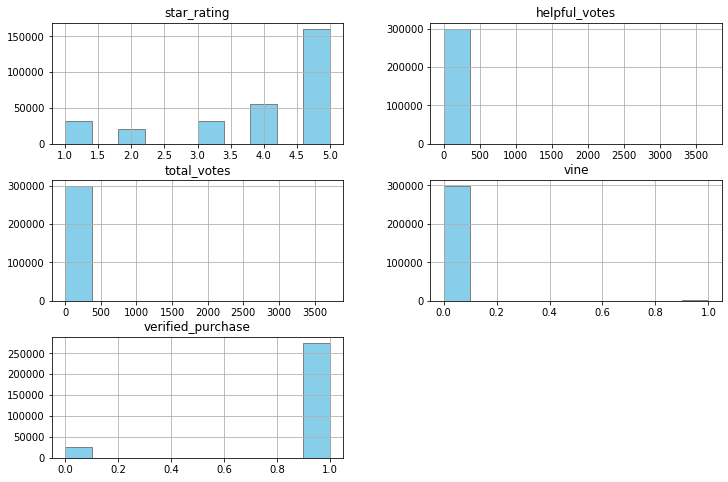

In [20]:
# Check the distribution of the star rating with the DataFrame | reference chart: https://www.datacamp.com/community/tutorials/histograms-matplotlib
# plt.hist(df.star_rating, bins='auto', color = "skyblue", ec='grey')
# plt.gca().set(title='Frequency Histogram | Review Stars |', ylabel='Frequency',xlabel = 'stars',alpha=0.7, rwidth=0.85);
# plt.show()

fig = plt.figure(figsize = (12,8))
ax = fig.gca()
df_discriptive.hist(ax=ax, color = "skyblue", ec='grey')
plt.show()

# Clustering per groups of product parent | votes per product parent
# Sentimet (from -ve) most common words for improvement | from (+ve) most common words for gap analysis
# we will need to scale our stars to min max
# then our scaled stars are our sentiment label, and text is the features? 


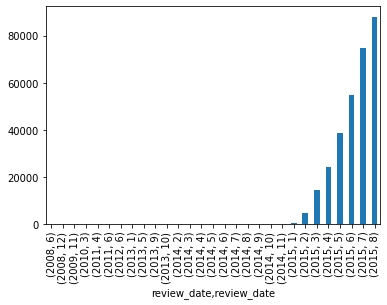

In [21]:
# Looking at year and month for review | seems we can extra clean outliers outside 2015 #todo
df.star_rating.groupby([df["review_date"].dt.year, df["review_date"].dt.month]).count().plot(kind="bar")

In [ ]:
# Looking at product parent | 
df.product_id.groupby([df["product_parent"],df['star_rating']]).count().plot(kind="bar")

In [ ]:
# Distribution of Amazon Product Ratings
ratings = df["star_rating"].value_counts()
numbers = ratings.index
quantity = ratings.values

custom_colors = ["skyblue", "yellowgreen", 'tomato', "blue", "red"]
plt.figure(figsize=(10, 8))
plt.pie(quantity, labels=numbers, colors=custom_colors)
central_circle = plt.Circle((0, 0), 0.5, color='white')
fig = plt.gcf()
fig.gca().add_artist(central_circle)
plt.rc('font', size=12)
plt.title("Distribution of Amazon Product Ratings", fontsize=20)
plt.show()

In [ ]:
def sentiment(row):
    
    '''This function returns sentiment value based on the star_rating from the user'''
    
    if row['star_rating'] == 3.0:
        val = 'Neutral'
    elif row['star_rating'] == 1.0 or row['star_rating'] == 2.0:
        val = 'Negative'
    elif row['star_rating'] == 4.0 or row['star_rating'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [ ]:
#Applying the function in our new column
df['sentiment'] = df.apply(sentiment, axis=1)
df.head()

In [ ]:
# (5) Feature engineer for data that is
# (a) relevant 
# (b) unique
# (c) correct 
# (d) not missing

# Drop data that is not a,b,c, or d
# Use one-hot encoding for nominal
# Reduce dimensions of your features

# Put features into dataframe
# Distribution of sentiment class
fig, axes = plt.subplots(1, figsize=(15,8))
fig.suptitle("Comparing Ratio of Neutral Negative and Positive ratings", fontsize = 25)
plt.tight_layout(pad = 3.5)
sns.countplot(x = "sentiment", data = df)
axes.set_xlabel("Sentiment", fontsize = 20)
axes.set_ylabel("Count", fontsize = 20)
sns.despine()

In [ ]:
# Group by product and Rating class
df.groupby("product_title")["review_body"].unique()

In [ ]:
# Group by product and Rating class
df.groupby("product_title")["product_id"].count()

In [ ]:
# Group by product and Rating class
df.groupby("product_title")["sentiment"].unique()

In [ ]:
# (4) Choose the label and features

In [ ]:
# (5) Feature engineer for data that is
# (a) relevant 
# (b) unique
# (c) correct 
# (d) not missing

# Drop data that is not a,b,c, or d
# Use one-hot encoding for nominal
# Reduce dimensions of your features

In [ ]:
# Plot number of reviews for top 50 products
products = df["product_id"].value_counts()
plt.figure(figsize=(12,8))
products[:10].plot(kind='bar')
plt.title("Number of Reviews for Top 50 Products")

In [ ]:
# Plot number of reviews for top 50 products
products = df["product_title"].value_counts()
plt.figure(figsize=(12,8))
products[:10].plot(kind='bar')
plt.title("Number of Reviews for Top 50 Products")

In [ ]:
# Word Count per Review type
from textblob import TextBlob
df['text_word_count']= df.apply(lambda row: len(row['review_body']), axis=1)
# df["text_word_count"] = temp_df["Text"].apply(lambda text: len(text.split()))


In [ ]:
df[df.star_rating==5].text_word_count.median()

In [ ]:
sns.boxplot(x='star_rating',y='text_word_count', data=df, palette='RdBu', showfliers=False)
plt.show()

In [ ]:
sns.boxplot(x='sentiment',y='text_word_count', data=df, palette='RdBu', showfliers=False)
plt.show()

In [ ]:
# (6) Confirm data is ready with further exploratory analysis




*   Maximum reviews are positive
*   Product with Max reviews is Tummy slimming belt
*   This shows people mainly target losing weight :)
*   Postive reviews has lesser words compared to Neutral and negative. Neutral commets are ones with most words. Which can be critic comment or unsatisfied customers.





### Popular words in Review

In [ ]:
pos = df_discriptive.loc[df['classes'] == 'positive']
pos = pos[0:25000]

neg = df.loc[df['classes'] == 'negative']
neg = neg[0:25000]

In [ ]:
!pip install nltk

In [ ]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import string
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')

def create_Word_Corpus(temp):
    words_corpus = ''
    for val in temp["review_body"]:
        text = str(val).lower()
        #text = text.translate(trantab)
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        for words in tokens:
            words_corpus = words_corpus + words + ' '
    return words_corpus
        


In [ ]:
# Generate a word cloud image
pos_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(pos))
neg_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(neg))

In [ ]:
# Plot cloud
def plot_Cloud(wordCloud):
    plt.figure( figsize=(20,10), facecolor='w')
    plt.imshow(wordCloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

In [ ]:
#Visuallizing popular positive words
plot_Cloud(pos_wordcloud)

In [ ]:
#Visuallizing popular negative words
plot_Cloud(neg_wordcloud)

### Data Split, Machine Learning

In [ ]:
# (7) Training, Testing (and/or Validation) data split 

# for example, 60/20/20

In [ ]:
# (7.b) If using Deep Learning, building the model

# Add Input Layer
# Add Hidden Layers
# Add Output

In [ ]:
# (8) Training the Machine Learning Model (i.e, Fitting the Model)

In [ ]:
# (9) Evaluate the model metrics for Training (and/or Validation) data

In [ ]:
# (10) Evaluate the model metris for Testing data


# If metrics are poor, optimize either (a) the data, (b) the hyperpamaters

In [ ]:
# (11) Use the model for prediction

In [ ]:
# (12) Write final predicted data  (e.g, to CSV or JSON, etc.)

In [ ]:
df_cleaned = df.head(100000)
df_cleaned['star_rating'].count()
df_cleaned['star_rating'].unique()
df_cleaned['star_rating'].value_counts()
# indexNames = df_cleaned[ df_cleaned['star_rating'] == 'star_rating' ].index
# df_cleaned.drop(indexNames,inplace=True)
# df_cleaned.dropna(inplace=True)

In [ ]:
from nltk.corpus import stopwords
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

In [ ]:
df_cleaned.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( df_cleaned['review_body'], df_cleaned['star_rating'], test_size=0.33, random_state=42)

In [ ]:
clf = Pipeline([
    ('vect', CountVectorizer(analyzer='word', ngram_range=(1, 2))),
    ('clf', LogisticRegression(max_iter=500,C=0.1,random_state=40,solver='newton-cg')),
])
clf = clf.fit(X_train, y_train)
accuracy_train=accuracy_score(y_train, clf.predict(X_train))
accuracy_test=accuracy_score(y_test, clf.predict(X_test))
print('Accuracy on train %f' %accuracy_train)
print('Accuracy on test %f' %accuracy_test)

In [ ]:
clf = Pipeline([
    ('vect',TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=500,C=0.1,random_state=40,solver='newton-cg')),
])
clf = clf.fit(X_train, y_train)
accuracy_train=accuracy_score(y_train, clf.predict(X_train))
accuracy_test=accuracy_score(y_test, clf.predict(X_test))
print('Accuracy on train %f' %accuracy_train)
print('Accuracy on test %f' %accuracy_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = Pipeline([
    ('vect', CountVectorizer(analyzer='word', ngram_range=(1, 2))),
    ('clf', DecisionTreeClassifier()),
])
clf = clf.fit(X_train, y_train)
accuracy_train=accuracy_score(y_train, clf.predict(X_train))
accuracy_test=accuracy_score(y_test, clf.predict(X_test))
print('Accuracy on train %f' %accuracy_train)
print('Accuracy on test %f' %accuracy_test)

In [ ]:
clf = Pipeline([
    ('vect',TfidfVectorizer()),
    ('clf', DecisionTreeClassifier()),
])
clf = clf.fit(X_train, y_train)
accuracy_train=accuracy_score(y_train, clf.predict(X_train))
accuracy_test=accuracy_score(y_test, clf.predict(X_test))
print('Accuracy on train %f' %accuracy_train)
print('Accuracy on test %f' %accuracy_test)

In [ ]:
from sklearn.svm import LinearSVC
clf = Pipeline([
    ('vect',TfidfVectorizer()),
    ('clf',LinearSVC()),
])
clf = clf.fit(X_train, y_train)
accuracy_train=accuracy_score(y_train, clf.predict(X_train))
accuracy_test=accuracy_score(y_test, clf.predict(X_test))
print('Accuracy on train %f' %accuracy_train)
print('Accuracy on test %f' %accuracy_test)

#### Using KNN

In [ ]:
def partition(x):
    if x<3:
        return 'Negative'
    elif x>3:
        return 'Positive'
    return 'Neutral'

actualScore = df['star_rating']
positiveNegative = actualScore.map(partition)
df['Score'] = positiveNegative

In [ ]:
df['Time'] = df['review_date']
sortedData = df.sort_values('product_id',axis=0,kind="quicksort", ascending=True)
final = sortedData.drop_duplicates(subset={"customer_id","Time","review_body"},keep="first",inplace=False)

final = final[final.helpful_votes >= final.total_votes-final.helpful_votes]

#As data is huge, due to computation limitation we will randomly select data. we will try to pick data in a way so that it doesn't make data imbalance problem
finalp = final[final.Score == 'Positive']
finalp = finalp.sample(frac=0.008,random_state=2) #0.055

finaln = final[final.Score == 'Negative']
finaln = finaln.sample(frac=0.1,random_state=1) #0.25

finalne = final[final.Score == 'Neutral']
finalne = finalne.sample(frac=0.02,random_state=4) #0.25

final = pd.concat([finalp,finaln, finalne],axis=0)

#sording data by timestamp so that it can be devided in train and test dataset for time based slicing.
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)

In [ ]:
import re
import string
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
all_neutral_words=[]
s=''

for sent in final['review_body'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'Positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'Negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    if(final['Score'].values)[i] == 'Neutral':
                        all_neutral_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words    
    final_string.append(str1)
    i+=1

In [ ]:
from sklearn.model_selection import cross_val_score

def find_optimal_k(X_train,y_train, myList):
   
    #creating odd list of K for KNN
    #myList = list(range(0,40))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k,n_jobs=8)
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)


    plt.figure(figsize=(10,6))
    plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Error Rate')

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    
    return optimal_k

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
 
count_vect = CountVectorizer() 
final_bow_count = count_vect.fit_transform(final_string)#final['Text'].values)

In [ ]:
from sklearn.preprocessing import StandardScaler

final_bow_np = StandardScaler(with_mean=False).fit_transform(final_bow_count )

In [ ]:
#We already have sorted data by timestamp so we will use first 70% of data as Train with cross validation and next 30% for test
import math
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X = final_bow_np
y = final['Score']

X_train =  final_bow_np[:math.ceil(len(final)*.7)] 
X_test = final_bow_np[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

"""
df_test = pd.read_csv('test.csv')

df_test = df_test.dropna()

X_test = df_test['review_body']
y_test = df_test['ratings']

count_vect_test = CountVectorizer() 
final_bow_count_test = count_vect.fit_transform(X_test)
final_bow_np_test = StandardScaler(with_mean=False).fit_transform(final_bow_count_test)

X_test = final_bow_np_test
"""

In [ ]:
import numpy as np

In [ ]:
myList = list(range(0,15))

optimal_k = find_optimal_k(X_train ,y_train,myList)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=optimal_k, n_jobs=8)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

In [ ]:
print("Accuracy for KNN model with Bag of words is ",round(accuracy_score(y_test ,pred),3))

### Table metrics with different modules

In [ ]:
def pred(proba,thresh, fpr ,tpr):
    """This function calculations and return the prediction with highest tpr and lowest tpr"""
    t=thresh[np.argmax(tpr*(1-fpr))] #t creates a numpy array with the max fpr and lowest tpr
    print("the maximum tpr*(1-fpr)",max(tpr*(1-fpr)),"for threshold",np.round(t,3))
    predictions=[]
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [ ]:
from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
cm=confusion_matrix(y, pred(y_train_predict, train_thresholds,train_fpr,train_tpr))
print(cm)

In [ ]:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

import seaborn as sn
df_cm=pd.DataFrame(cm,index=[0,1],columns=[0,1])
plt.figure(figsize = (5,5))
plt.title("Train Confusion matrix")
ax=sn.heatmap(df_cm, annot=True,fmt='g')
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#### EDA by Spacy

In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

In [ ]:
stopwords = list(STOP_WORDS)

In [ ]:
import string
punctuations = string.punctuation
from spacy.lang.en import English
parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [word.lemma_.lower() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
    mytokens = [word for word in mytokens if word not in stopwords and word not in punctuations]
    return mytokens
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
#Custom Transformer using spaCy
class predictors(TransformerMixin):
    
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self,deep=True):
        return{}
    
# Basic function to clean the text
def clean_text(text):
    return text.strip().lower()
tfdifVect = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [ ]:
from spacy import displacy

In [ ]:
# Breaking down a review into dependencies
doc = nlp(df['review_body'][8]) 
displacy.render(doc,style='dep',jupyter=True)

In [ ]:
#X = data.drop('star_rating',axis=1)
X = df['review_body']
y = df['sentiment']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

#### Support Vector Machines

In [ ]:
from sklearn.svm import LinearSVC
classifier = LinearSVC()

In [ ]:
pipe = Pipeline([('cleaner', predictors()),
                 ('tfidfVect', tfdifVect),
                ('classifier',classifier),])

In [ ]:
y_train

In [ ]:
from sklearn.svm import LinearSVC
classifier = LinearSVC()

In [ ]:
pipe = Pipeline([('cleaner', predictors()),
                 ('tfidfVect', tfdifVect),
                ('classifier',classifier),])

In [ ]:
pipe.fit(X_train, y_train)

In [ ]:
sample_prediction = pipe.predict(X_test)

In [ ]:
count = 1
for (sample,pred) in zip(X_test[0:10],sample_prediction[0:10]):
    print('\n',count,')')
    print(sample,"'PREDICTION':", pred)
    count += 1

In [ ]:
#Test Accuracy
print("Accuracy:", pipe.score(X_test,y_test))

In [ ]:
pipe.predict(["but fitting small and bad also costly and overpriced"])

In [ ]:
pipe.predict(["Not great"])

#### Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
classifier =  LogisticRegression()

In [ ]:
pipe = Pipeline([('cleaner', predictors()),
                ('tfidfVect', tfdifVect),
                ('classifier',classifier)])

In [ ]:
pipe.fit(X_train,y_train)

In [ ]:
sample_prediction = pipe.predict(X_test)

In [ ]:
#Test Accuracy
print("Accuracy:", pipe.score(X_test,y_test))

In [ ]:
pipe.predict(["but fitting small and bad also costly and overpriced"])

In [ ]:
pipe.predict(["Not great"])

#### Decision Trees


In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
classifier = DecisionTreeClassifier()

In [ ]:
pipe = Pipeline([('cleaner', predictors()),
                ('tfidfVect', tfdifVect),
                ('classifier',classifier)])

In [ ]:
pipe.fit(X_train,y_train)

In [ ]:
sample_prediction = pipe.predict(X_test)

In [ ]:
print("Accuracy:", pipe.score(X_test,y_test))

In [ ]:
pipe.predict(["but fitting small and bad also costly and overpriced"])

In [ ]:
pipe.predict(["Not great"])

#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
classifier = RandomForestClassifier(n_estimators = 100, random_state = 42)

In [ ]:
pipe = Pipeline([('cleaner', predictors()),
                ('tfidfVect', tfdifVect),
                ('classifier',classifier)])

In [ ]:
pipe.fit(X_train,y_train)

In [ ]:
sample_prediction = pipe.predict(X_test)

In [ ]:
print("Accuracy:", pipe.score(X_test,y_test))

In [ ]:
pipe.predict(["but fitting small and bad also costly and overpriced"])

In [ ]:
pipe.predict(["Not good"])

In [ ]:
pipe.predict(["Nice dress, good fitting"])

In [ ]:
pipe.predict(["perfect size, good material"])

# precision data





```

```



In [ ]:
URL = "/content/cleaned_apparel_dataset.csv"


In [ ]:
# importing necessary libraries
import pandas as pd
import numpy as np

In [ ]:
# Installing the transformers package for BERT
!pip install transformers

In [ ]:
import torch
# Progress bar library
from tqdm.notebook import tqdm
# Tokenizer for bert
from transformers import BertTokenizer
# The dataset off which the model will be trained
from torch.utils.data import TensorDataset
# Model
from transformers import BertForSequenceClassification

# Loading the dataframe into memory
df = pd.read_csv(URL)

In [ ]:
# Checking the amount of Null values
df['review_body'].isna().sum()

In [ ]:
df.shape

In [ ]:
df

In [ ]:
#Function that converts overall (5 classes) to y (3 classes) 
def classify(x):
    if x == 5.0 or x==4.0:
        return 2
    if x==3.0:
        return 1
    return 0

In [ ]:
# Building column y with the classify function
df['y'] = df['star_rating'].apply(classify)

In [ ]:
df

In [ ]:
# Checking distribution of data
df['y'].value_counts()

In [ ]:
# Creating a dictionary which contains all unique attributes in y, here these are the classes
possible_labels = df.y.unique()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = int(possible_label)
label_dict


In [ ]:
# Changing column name from y to label for clarity
df['label'] = [label_dict[str_label] for str_label in df['y']]

In [ ]:
# Splitting the dataset into a 85-15 train-test split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

# creating a column data_type to denote whether each record is for test or train
df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.groupby(['y', 'label', 'data_type']).count()

In [ ]:
# Initializing tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)              
# Encoding training batch                           
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].review_body.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)
# Encoding validation batch                           
encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].review_body.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

# Extracting variables from encoded objects for ease of use
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']

# creating tensors
labels_val = torch.tensor(df[df.data_type=='val'].label.values)
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [ ]:
# Initializing the model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

In [ ]:
# Import and initialization of dataloaders and batch size hyperparameter
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [ ]:
# Importing the adam optimizer and a scheduler to manage learning rate in an optimal fashion
from transformers import AdamW, get_linear_schedule_with_warmup

# Initializing the optimizer (uses the adam algorithm - an extension to stochastic gradient descent)
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
# Setting epoch hyperparameter
epochs = 3

# Scheduler to increase learning rate for a certain number of steps then linearly deacrese the same
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [ ]:
# Defining functions for f1 score and accuracy
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    correct=0
    total=0
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        correct+=len(y_preds[y_preds==label])
        total+=len(y_true)
    print(f'Bert Model Accuracy Overall :',correct/total)

In [ ]:
#to check GPU vs CPU - based on whether the local/hosted runtime has an nvidia GPU available or not
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

In [ ]:
import random

# Sets torchs seed to randomize to enable usage of torch.random()
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Evaluate function to be used along with tqdm to display the live progress of the model training, calculates average loss, predictions and true values.
def evaluate(dataloader_val):

    # used to turn off layers that dont perform as expected
    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
  
# Train the model
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
      
    # Write results  
    tqdm.write(f'\nEpoch {epoch}')
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')

    #Save the finetuned model per epoch
    torch.save(model.state_dict(), f'/content/drive/MyDrive/bertmodel{epoch}.model')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

In [ ]:
# Display final accuracy per class
accuracy_per_class(predictions, true_vals)